In [106]:
import pandas as pd
import numpy as np
ember_dataset = pd.read_csv("data/EMBER.csv", sep=';', encoding='latin-1')
ember_dataset.head()

,Date,Year,Month,Area,Area.Type,Variable,Variable.Type,Generation (GWh),YoY change (%),YoY change (GWh),Cumul. Generation (GWh),Cumul. YoY change (%),Cumul. YoY change (GWh),Demand Flag
0,janv-18,2018,1,Austria,EU Country,Demand,Demand,5971,NaN,NaN,5971.0,NaN,NaN,NaN
1,janv-18,2018,1,Austria,EU Country,Production,Production,5219,NaN,NaN,5219.0,NaN,NaN,NaN
2,janv-18,2018,1,Austria,EU Country,Net imports,Net imports,594,NaN,NaN,594.0,NaN,NaN,NaN
3,janv-18,2018,1,Austria,EU Country,Statistical difference,Statistical difference,158,NaN,NaN,158.0,NaN,NaN,NaN
4,janv-18,2018,1,Austria,EU Country,Gas,Fossil,1144,NaN,NaN,1144.0,NaN,NaN,NaN


# Netherlands

In [107]:
NLD = pd.read_csv('data/netherlands_ENTSOE_2020.csv', sep=',')
NLD_mask= ember_dataset['Area']=='Netherlands'
NLD_EMBER = ember_dataset[NLD_mask]
NLD_mask= NLD_EMBER['Year']==2020
NLD_EMBER = NLD_EMBER[NLD_mask]
NLD_EMBER.Date.unique()

array(['janv-20', 'févr-20', 'mars-20', 'avr-20', 'mai-20', 'juin-20',
       'juil-20', 'août-20', 'sept-20', 'oct-20', 'nov-20', 'déc-20'],
      dtype=object)

In [119]:
dico_NLD = {'Biomass  - Actual Aggregated [MW]': 'Bioenergy', 
        'Fossil Gas  - Actual Aggregated [MW]': 'Gas', 
        'Fossil Hard coal  - Actual Aggregated [MW]': 'Hard coal',
        'Hydro Run-of-river and poundage  - Actual Aggregated [MW]': 'Hydro', 
        'Nuclear  - Actual Aggregated [MW]': 'Nuclear', 
        'Other  - Actual Aggregated [MW]' : 'Gas', 
        'Solar  - Actual Aggregated [MW]':'Solar',
        'Wind Offshore  - Actual Aggregated [MW]' : 'Wind',
        'Wind Onshore  - Actual Aggregated [MW]': 'Wind', 
}
dico = {'Biomass  - Actual Aggregated [MW]': 'Bioenergy', 
        'Fossil Gas  - Actual Aggregated [MW]': 'Gas', 
        'Fossil Hard coal  - Actual Aggregated [MW]': 'Hard coal',
        'Hydro Run-of-river and poundage  - Actual Aggregated [MW]': 'Hydro', 
        'Nuclear  - Actual Aggregated [MW]': 'Nuclear', 
        'Other  - Actual Aggregated [MW]' : 'Gas', 
        'Solar  - Actual Aggregated [MW]':'Solar',
        'Wind Offshore  - Actual Aggregated [MW]' : 'Wind',
        'Wind Onshore  - Actual Aggregated [MW]': 'Wind', 
        'Hydro Pumped Storage  - Actual Aggregated [MW]': 'Hydro',
        'Hydro Pumped Storage  - Actual Consumption [MW]':'Hydro',
        'Hydro Water Reservoir  - Actual Aggregated [MW]':'Hydro',
        'Other renewable  - Actual Aggregated [MW]' : 'Solar',

}

def get_keys(dic, val) :
    res = []
    for key, value in dic.items():
         if val == value:
             res.append(key)
    return res

def create_simple_dataset(df, feature, dico =dico, time_scale = 1 ) :
    dataset = df.copy()
    dates = []
    for i in dataset.index :
        dates.append(dataset.iloc[i]['MTU'][3:5])
    dataset['MTU'] = np.array(dates)    
    dataset.fillna(method='ffill')
    res = dataset.groupby(['MTU'])[dataset.columns[2:23]].agg('sum')/time_scale
 
    A = get_keys(dico, feature)
    values = np.zeros(12)
    for i in range (12) : 
        for val in A  : 
            if val in res.columns:
                values[i]+= res[val].iloc[i]
    res[feature] = np.transpose(values)
    return pd.DataFrame(res[feature])

    
    

In [109]:
def feature_from_EMBER(df, country, year, feature) :
    df_mask= df['Area']==country
    df_EMBER = df[df_mask]
    df_mask= df_EMBER['Year']==year
    df_EMBER = df_EMBER[df_mask]

    res_ar = np.zeros(12)
    df_mask = df_EMBER['Variable'] == feature
    df_EMBER = df_EMBER[df_mask]

    res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
    
    year_suff = str(year)
    year_suff = year_suff[2:4]

    
    month_dict = {'janv-'+ year_suff : 1, 'févr-'+ year_suff :2, 'mars-'+year_suff :3, 'avr-'+year_suff:4, 'mai-'+year_suff:5, 'juin-'+year_suff:6,
       'juil-'+year_suff:7, 'août-'+year_suff:8, 'sept-'+year_suff:9, 'oct-'+year_suff:10, 'nov-'+year_suff:11, 'déc-'+year_suff:12}
    res= pd.DataFrame(df_EMBER['Date'])
    month = np.array([month_dict[df_EMBER['Date'].iloc[i]] for i in range(12)])
    res['Month'] = np.transpose(month)
    res[feature]=np.transpose(res_ar)

    
    return res

def create_comparison(entsoe_df, ember_df, country, year, feature, time_scale=1) :
   entsoe = create_simple_dataset(entsoe_df, feature, time_scale=time_scale)
   EMBER = feature_from_EMBER(ember_df, country, year, feature)
   entsoe[feature+'_EMBER']= np.array(EMBER[feature])
   entsoe['error'] = np.abs(np.array(EMBER[feature])-np.array(entsoe[feature]))/np.array(EMBER[feature])
   return entsoe
   

    

In [110]:
ember_dataset

,Date,Year,Month,Area,Area.Type,Variable,Variable.Type,Generation (GWh),YoY change (%),YoY change (GWh),Cumul. Generation (GWh),Cumul. YoY change (%),Cumul. YoY change (GWh),Demand Flag
0,janv-18,2018,1,Austria,EU Country,Demand,Demand,5971,NaN,NaN,5971.0,NaN,NaN,NaN
1,janv-18,2018,1,Austria,EU Country,Production,Production,5219,NaN,NaN,5219.0,NaN,NaN,NaN
2,janv-18,2018,1,Austria,EU Country,Net imports,Net imports,594,NaN,NaN,594.0,NaN,NaN,NaN
3,janv-18,2018,1,Austria,EU Country,Statistical difference,Statistical difference,158,NaN,NaN,158.0,NaN,NaN,NaN
4,janv-18,2018,1,Austria,EU Country,Gas,Fossil,1144,NaN,NaN,1144.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16527,sept-21,2021,9,United Kingdom,non EU Country,Bioenergy,Renewables,1109,10,103.0,13808.0,4,504.0,NaN
16528,sept-21,2021,9,United Kingdom,non EU Country,Hydro,Renewables,122,-49,-118.0,2001.0,-32,-951.0,NaN
16529,sept-21,2021,9,United Kingdom,non EU Country,Solar,Renewables,1010,-12,-136.0,9972.0,-8,-922.0,NaN
16530,sept-21,2021,9,United Kingdom,non EU Country,Wind,Renewables,3991,-25,-1348.0,42577.0,-21,-11338.0,NaN


In [111]:
FRA =pd.read_csv('data/france_ENTSOE_2020.csv', sep=',')
create_comparison(FRA, ember_dataset, 'France', 2020, 'Solar', time_scale = 1)

<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000


,Solar,Solar_EMBER,error
MTU,,,
01,455756.0,456000.0,0.000535
02,685391.0,685000.0,0.000571
03,1052372.0,1054000.0,0.001545
04,1294267.0,1294000.0,0.000206
05,1548259.0,1548000.0,0.000167
06,1384686.0,1387000.0,0.001668
07,1666903.0,1667000.0,0.000058
08,1458254.0,1458000.0,0.000174
09,1177037.0,1180000.0,0.002511


In [112]:
feature_from_EMBER(ember_dataset, 'Netherlands', 2020, 'Wind').describe()

<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000


,Month,Wind
count,12.000000,1.200000e+01
mean,6.500000,1.287833e+06
std,3.605551,4.253770e+05
min,1.000000,8.290000e+05
25%,3.750000,8.892500e+05
50%,6.500000,1.224500e+06
75%,9.250000,1.645250e+06
max,12.000000,1.957000e+06


In [113]:
def features_to_monitor(df, country, year, dico) :
    df_mask= df['Area']==country
    df_EMBER = df[df_mask]
    df_mask= df_EMBER['Year']==year
    df_EMBER = df_EMBER[df_mask]
    res = []
    resbis = df_EMBER.Variable.unique() 
    print(resbis)
    for a in resbis :
        if a in dico.values() :
            res.append(a)
    return res

In [114]:
import matplotlib.pyplot as plt
def plot_errors(entsoe_df, ember_df, country, year, time_scale=1, dico = dico) :
    features_outlook= features_to_monitor(ember_df, country, year, dico)
    print(features_outlook)
    for i in features_outlook :
        df = create_comparison(entsoe_df, ember_df, country, year, i, time_scale = time_scale)
        plt.plot(np.arange(12), df['error'], label= i)
        plt.legend()
    
    return None
        

['Demand' 'Production' 'Net imports' 'Statistical difference' 'Gas'
 'Hard Coal' 'Bioenergy' 'Solar' 'Wind' 'Nuclear' 'Waste']
['Gas', 'Bioenergy', 'Solar', 'Wind', 'Nuclear']


<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000


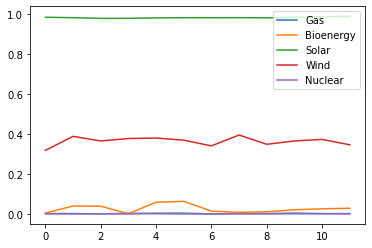

In [120]:
plot_errors(NLD, ember_dataset, 'Netherlands', 2020, 4)

In [122]:
create_comparison(NLD, ember_dataset,'Netherlands', 2020, 'Solar', time_scale = 4)

<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000


,Solar,Solar_EMBER,error
MTU,,,
01,2389.50,138000.0,0.982685
02,4636.50,238000.0,0.980519
03,14980.50,651000.0,0.976988
04,23086.50,1015000.0,0.977255
05,25380.00,1228000.0,0.979332
06,21118.75,1073000.0,0.980318
07,20021.75,1019000.0,0.980352
08,19614.25,1012000.0,0.980618
09,15394.50,763000.0,0.979824


['Demand' 'Production' 'Net imports' 'Statistical difference' 'Gas'
 'Hard Coal' 'Other fossil' 'Bioenergy' 'Hydro' 'Other renewables' 'Solar'
 'Wind' 'Waste']
['Gas', 'Bioenergy', 'Hydro', 'Solar', 'Wind']


<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000


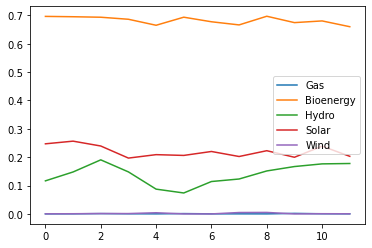

In [123]:


ITA = pd.read_csv('data/italy_ENTSOE_2020.csv', sep=',')
plot_errors(ITA, ember_dataset, 'Italy', 2020, 1, dico)

['Demand' 'Production' 'Net imports' 'Statistical difference' 'Bioenergy'
 'Hydro' 'Wind' 'Nuclear']
['Bioenergy', 'Hydro', 'Wind', 'Nuclear']


<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000
<ipython-input-109-77493e5ec896>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_ar = res_ar+np.array(df_EMBER[df_mask]['Generation (GWh)'])*1000


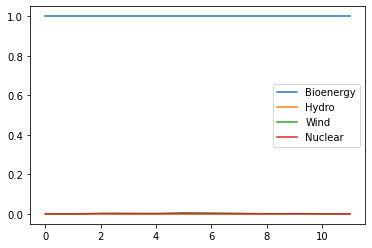

In [124]:

SWE = pd.read_csv('data/sweden_ENTSOE_2020.csv', sep=',')
plot_errors(SWE, ember_dataset, 'Sweden', 2020, 1, dico)